In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv('../data/raw_data/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.loc['2020-01-01':'2024-12-31']
df = df.astype(float)

In [4]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1258 non-null   float64
 1   high    1258 non-null   float64
 2   low     1258 non-null   float64
 3   close   1258 non-null   float64
 4   volume  1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


In [6]:
print(df.describe())

              open         high          low        close        volume
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03
mean    152.022500   153.707452   150.471751   152.177631  9.057384e+07
std      42.016644    42.214241    41.849262    42.073135  5.325460e+07
min      55.350235    55.452160    51.595990    54.449894  2.323470e+07
25%     126.388669   128.070217   124.935152   126.946348  5.546825e+07
50%     150.580333   152.511346   148.819389   150.761009  7.627980e+07
75%     176.636614   178.390041   175.258390   176.831444  1.077425e+08
max     257.906429   259.814335   257.347047   258.735504  4.265100e+08


In [7]:
n = len(df)
print(f'Len data: {n}')
bins = int(np.sqrt(n))
print(f'Bins: {bins}')

Len data: 1258
Bins: 35


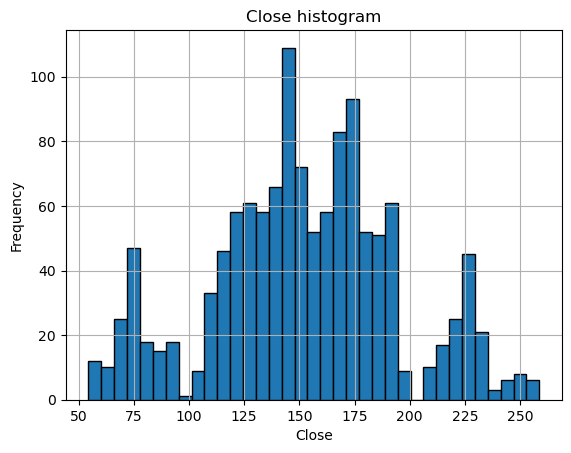

In [8]:
df['close'].hist(bins=bins, edgecolor='black')
plt.title('Close histogram')
plt.xlabel('Close')
plt.ylabel('Frequency')
plt.show()

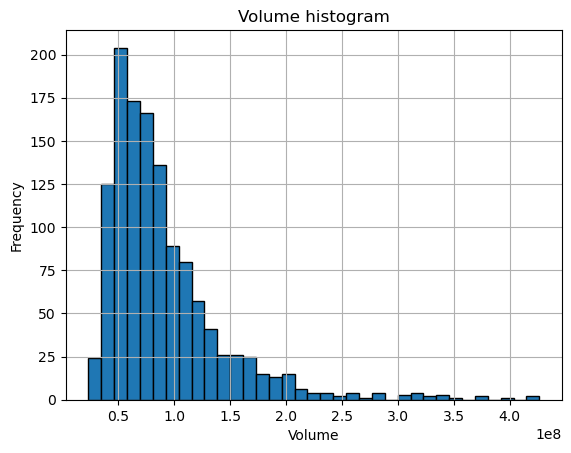

In [9]:
df['volume'].hist(bins=bins, edgecolor='black')
plt.title('Volume histogram')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='date'>

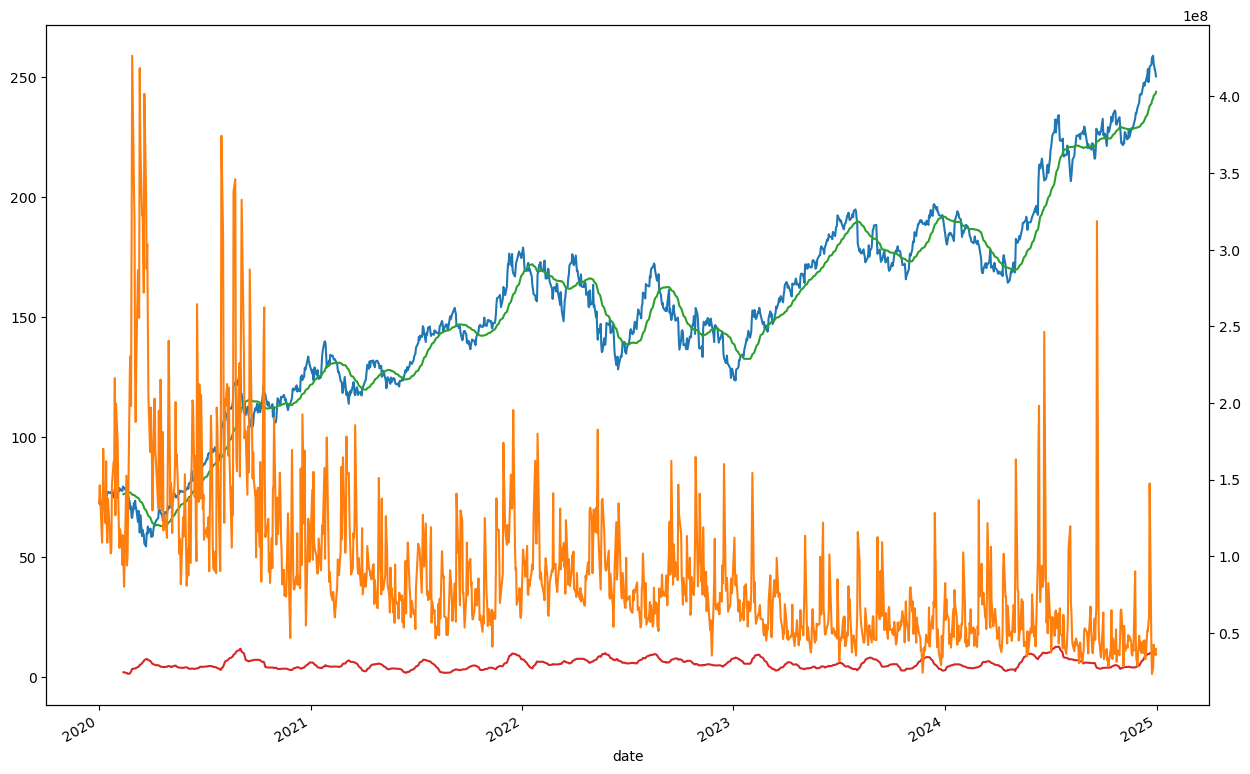

In [10]:
plt.figure(figsize=(15, 10))
df['close'].plot()
df['volume'].plot(secondary_y=True)
df['close'].rolling(window=30).mean().plot()
df['close'].rolling(window=30).std().plot()

C:\Users\santi\AppData\Local\Temp\ipykernel_12912\1865928357.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['close'].resample('B').mean().plot()
C:\Users\santi\AppData\Local\Temp\ipykernel_12912\1865928357.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['close'].resample('B').mean().plot()


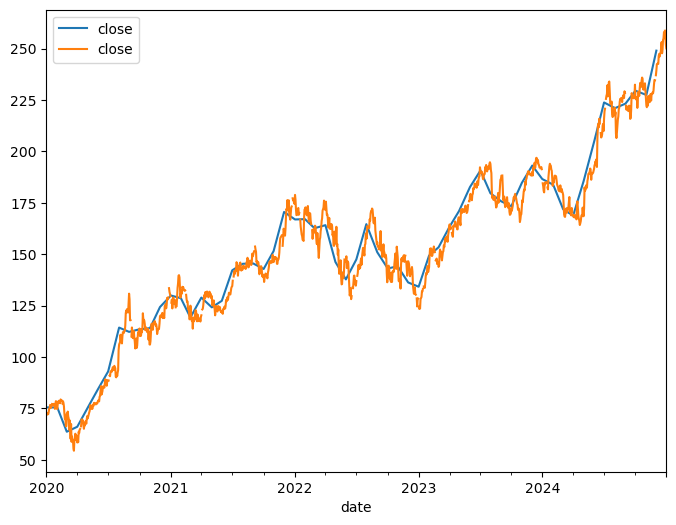

In [11]:
plt.figure(figsize=(8, 6))
df['close'].resample('M').mean().plot()
df['close'].resample('B').mean().plot()
plt.legend()

C:\Users\santi\AppData\Local\Temp\ipykernel_12912\3414365292.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['volume'].resample('B').median().plot()
C:\Users\santi\AppData\Local\Temp\ipykernel_12912\3414365292.py:3: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df['volume'].resample('B').median().plot()


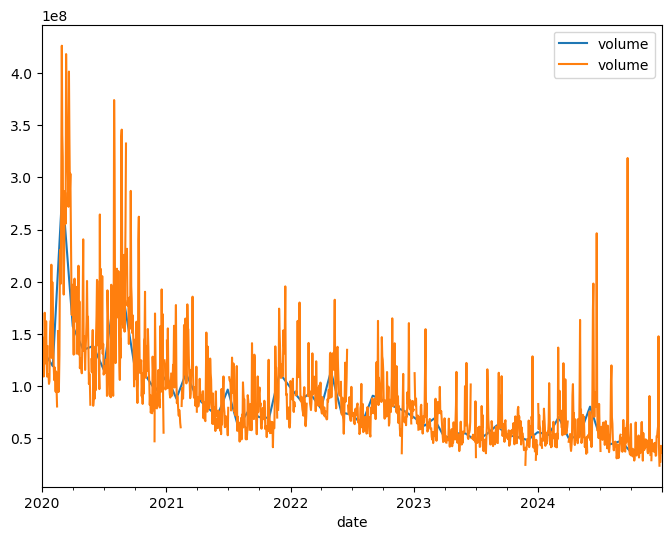

In [12]:
plt.figure(figsize=(8, 6))
df['volume'].resample('M').median().plot()
df['volume'].resample('B').median().plot()
plt.legend()

In [13]:
df['close_7_roll'] = df['close'].rolling(7).mean()
df['close_21_roll'] = df['close'].rolling(21).mean()
df['close_63_roll'] = df['close'].rolling(63).mean()

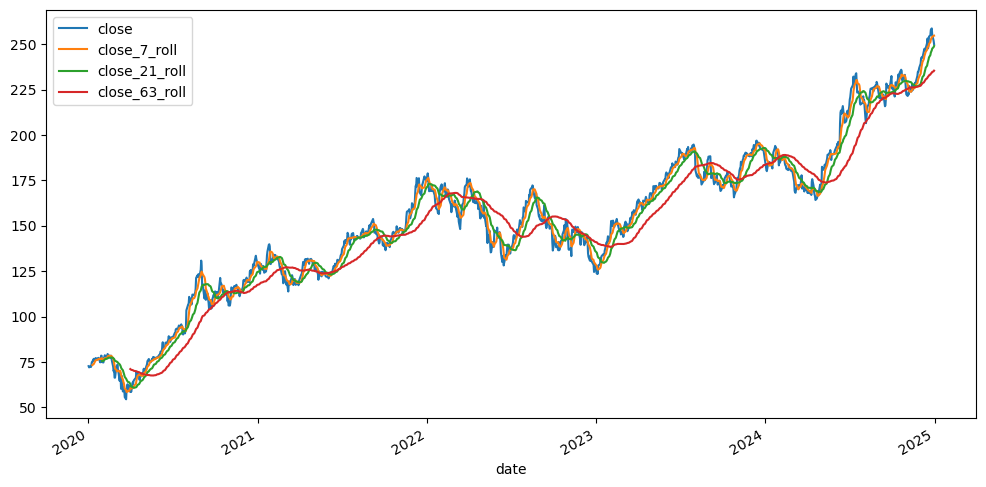

In [14]:
plt.figure(figsize=(12, 6))
df['close'].plot()
df['close_7_roll'].plot()
df['close_21_roll'].plot()
df['close_63_roll'].plot()
plt.legend()

In [15]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

price_columns = ['close', 'volume']
outliers_count = {col: count_outliers(df[col]) for col in price_columns}
print(outliers_count)

{'close': 7, 'volume': 68}


c:\Users\santi\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


Text(0.5, 1.0, 'Boxplot of close')

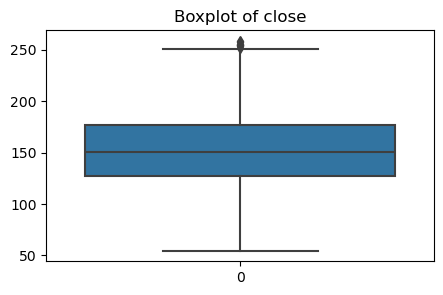

In [16]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['close'])
plt.title('Boxplot of close')

c:\Users\santi\anaconda3\Lib\site-packages\seaborn\categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


Text(0.5, 1.0, 'Boxplot of volume')

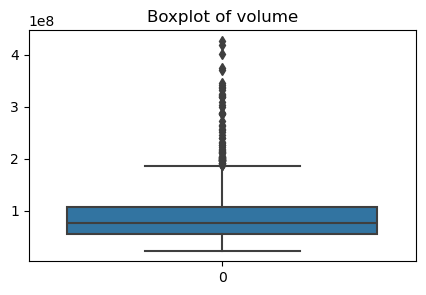

In [17]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=df['volume'])
plt.title('Boxplot of volume')

In [18]:
df.drop(['close_7_roll', 'close_21_roll', 'close_63_roll'], axis=1, inplace=True)

In [19]:
df['sma_7'] = df['close'].rolling(7, min_periods=1).mean()
df['sma_21'] = df['close'].rolling(21, min_periods=1).mean()
df['sma_63'] = df['close'].rolling(63, min_periods=1).mean()
df['sma_252'] = df['close'].rolling(252, min_periods=1).mean()

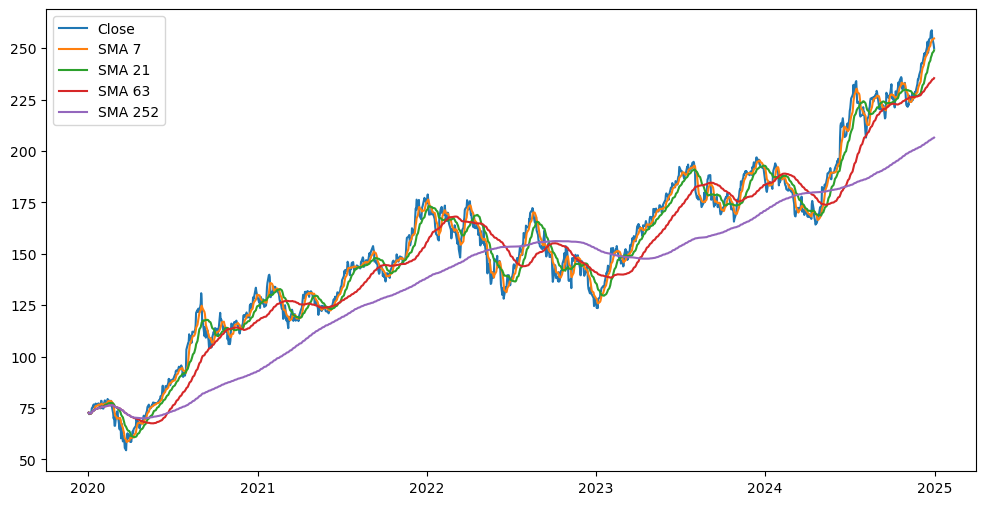

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close')
plt.plot(df['sma_7'], label='SMA 7')
plt.plot(df['sma_21'], label='SMA 21')
plt.plot(df['sma_63'], label='SMA 63')
plt.plot(df['sma_252'], label='SMA 252')
plt.legend()
plt.show()

In [21]:
df['log_close'] = np.log(df['close'])
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
df['log_returns_7'] = df['log_returns'].rolling(7, min_periods=1).mean()
df['log_returns_21'] = df['log_returns'].rolling(21, min_periods=1).mean()

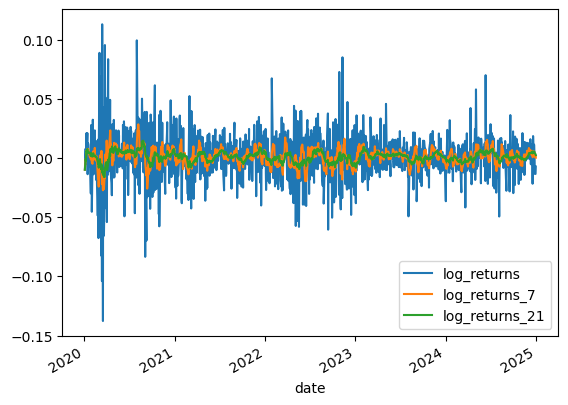

In [22]:
df['log_returns'].plot()
df['log_returns_7'].plot()
df['log_returns_21'].plot()
plt.legend()

In [23]:
df['volatility_7'] = df['log_returns'].rolling(7, min_periods=1).std()
df['volatility_21'] = df['log_returns'].rolling(21, min_periods=1).std()
df['volatility_63'] = df['log_returns'].rolling(63, min_periods=1).std()
df['volatility_252'] = df['log_returns'].rolling(252, min_periods=1).std()

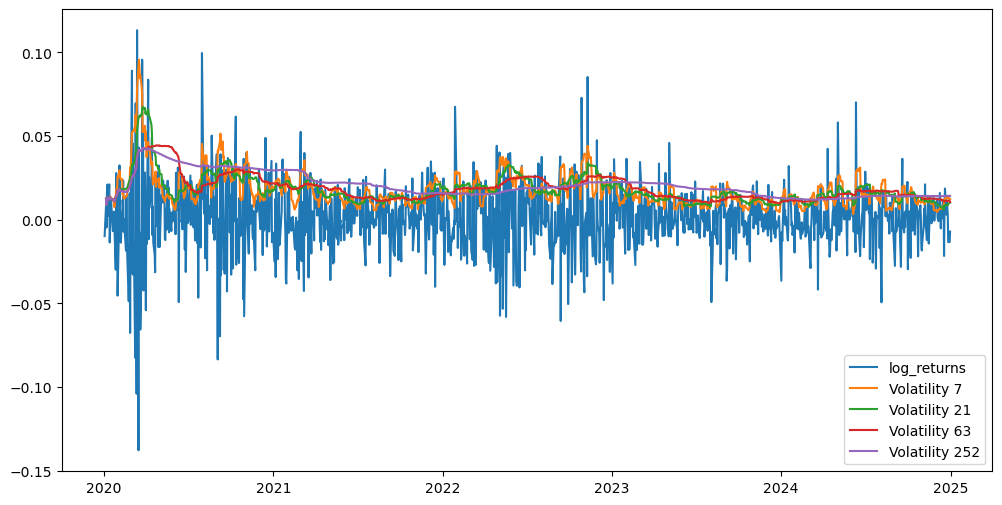

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df['log_returns'], label='log_returns')
plt.plot(df['volatility_7'], label='Volatility 7')
plt.plot(df['volatility_21'], label='Volatility 21')
plt.plot(df['volatility_63'], label='Volatility 63')
plt.plot(df['volatility_252'], label='Volatility 252')
plt.legend()
plt.show()

In [25]:
df['ema_7'] = df['close'].ewm(span=7, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()
df['ema_63'] = df['close'].ewm(span=63, adjust=False).mean()
df['ema_252'] = df['close'].ewm(span=252, adjust=False).mean()

In [26]:
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14, min_periods=1).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=1).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

In [27]:
df['bb_upper'] = df['sma_21'] + 2 * df['volatility_21']
df['bb_lower'] = df['sma_21'] - 2 * df['volatility_21']

In [28]:
result = adfuller(df['log_returns'].dropna())

In [29]:
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Lags used: {result[2]}')
print(f'Number of observations: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] > 0.05:
    print('Data is not stationary (fail to reject H0)')
else:
    print('Data is stationary (reject H0)')

ADF Statistic: -11.284371984966613
p-value: 1.4300902191533857e-20
Lags used: 8
Number of observations: 1248
Critical Values:
	1%: -3.4356006420838963
	5%: -2.8638586845641063
	10%: -2.5680044958343604
Data is stationary (reject H0)


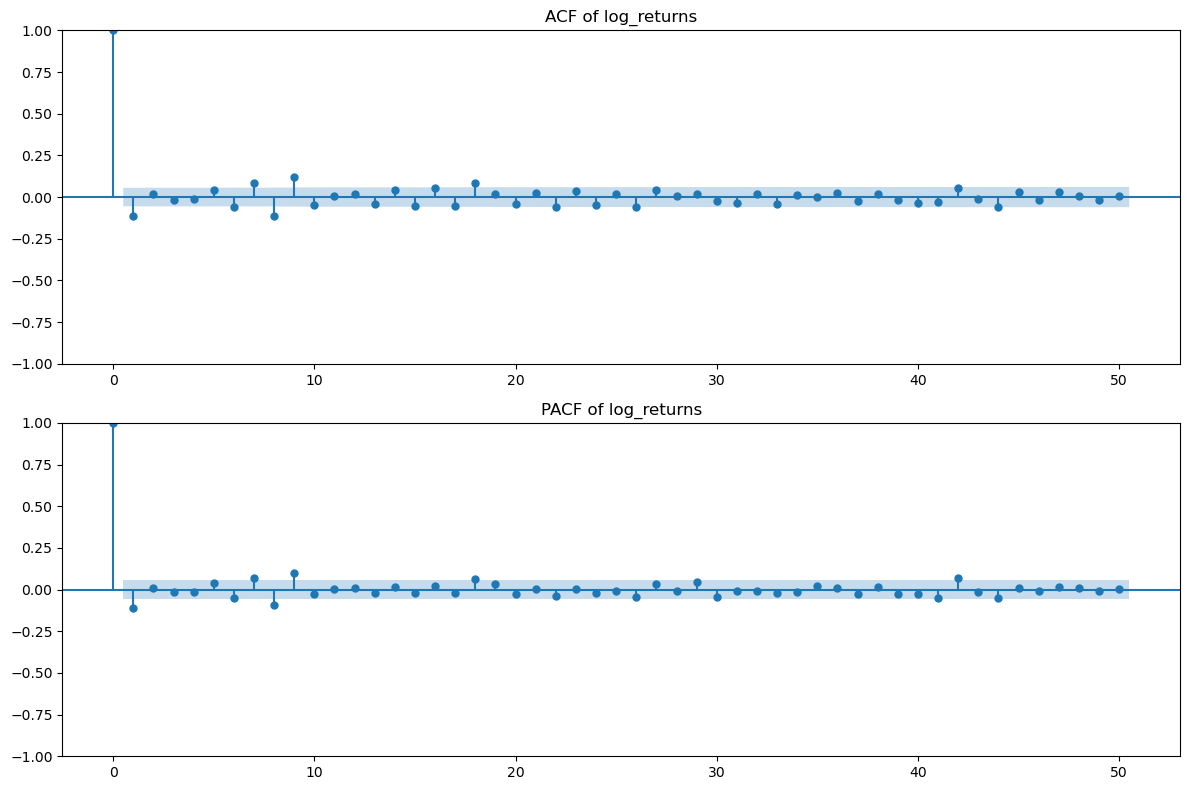

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(df['log_returns'].dropna(), lags=50, ax=ax[0])
ax[0].set_title('ACF of log_returns')
sm.graphics.tsa.plot_pacf(df['log_returns'].dropna(), lags=50, ax=ax[1])
ax[1].set_title('PACF of log_returns')
plt.tight_layout()
plt.show()

# Tendency analysis and seasonality

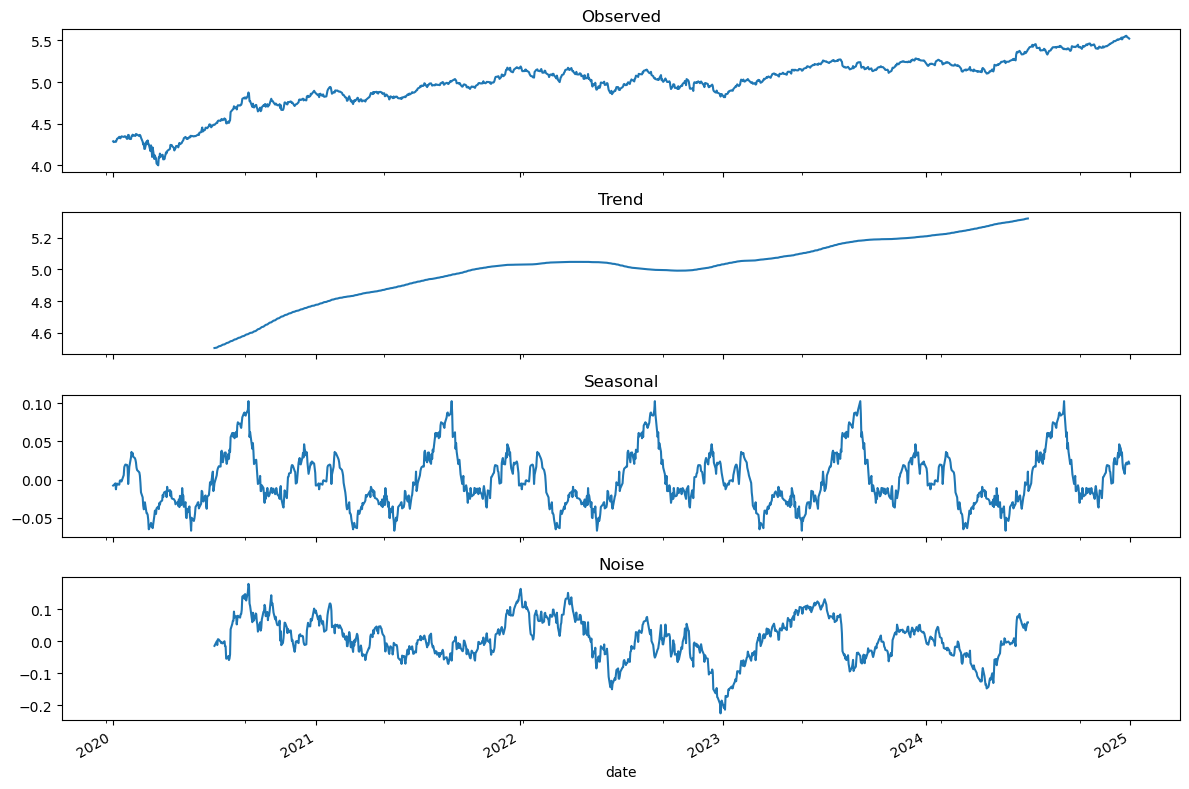

In [31]:
decomposition = seasonal_decompose(df['log_close'], model='additive', period=252)
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Noise')
plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

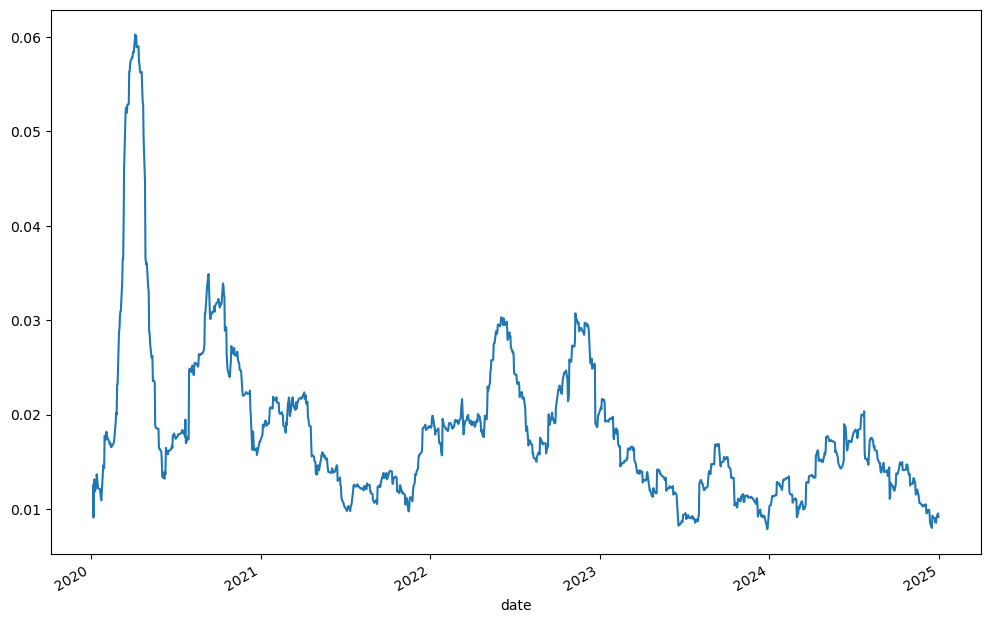

In [32]:
df['volatility_30'] = df['log_returns'].rolling(30, min_periods=1).std()

plt.figure(figsize=(12, 8))
df['volatility_30'].plot()

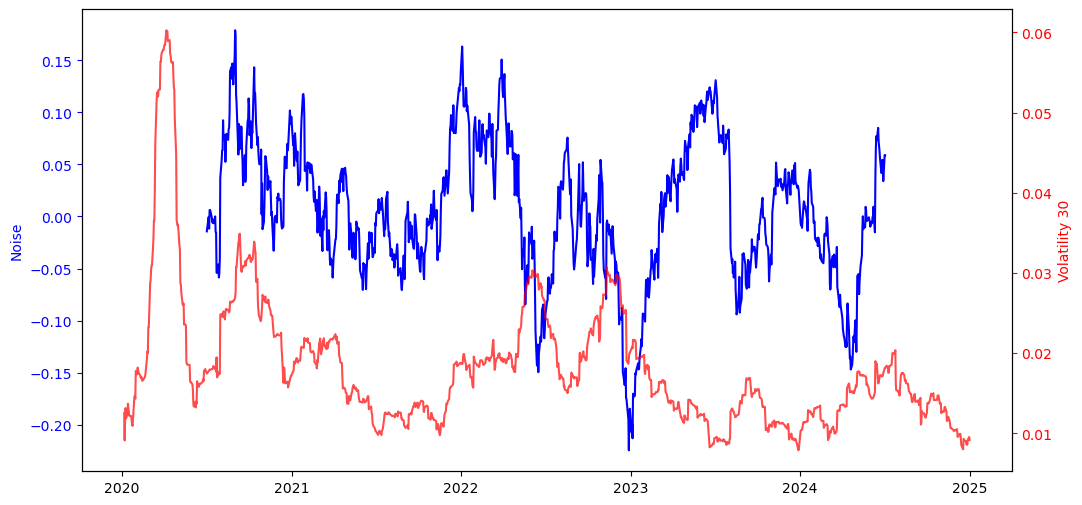

In [33]:
fig, ax1 = plt.subplots(figsize=(12, 6))

noise = decomposition.resid.dropna()
ax1.plot(noise, color='blue', label='Noise')
ax1.set_ylabel('Noise', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.plot(df['volatility_30'], color='red', label='Volatility 30', alpha=0.7)
ax2.set_ylabel('Volatility 30', color='red')
ax2.tick_params('y', colors='red')

plt.show()

In [37]:
correl = noise.corr(df['volatility_30'])
print(f'Correlation between noise and volatility_30: {correl}')


Correlation between noise and volatility_30: -0.007983024086033639
